# Task: Comparing 3 pretrained models, including the Xception Model for Transfer Learning using the tf_flowers dataset.

## 1. Loading and Studying the Dataset:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

2023-11-16 02:57:23.780990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 02:57:24.392326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/pthapa2/.conda/envs/opt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Loading the tf_flowers dataset
dataset, info = tfds.load("tf_flowers",as_supervised=True, with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/home/pthapa2/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


2023-11-16 02:57:26.731877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78923 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:08:00.0, compute capability: 8.0


In [5]:
# Class Label
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
# Total number of class
n_class = info.features["label"].num_classes
n_class

5

In [7]:
# Total size of dataset
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [8]:
# Spliting the dataset into train, validation and test data:
train_set_raw, valid_set_raw, test_set_raw = tfds.load("tf_flowers", split=["train[:80%]", "train[80%:90%]", "train[90%:]"], as_supervised=True)

2023-11-16 02:57:27.682498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-11-16 02:57:27.682835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]


(333, 500, 3)
(212, 320, 3)
(240, 320, 3)
(240, 320, 3)
(317, 500, 3)
(212, 320, 3)
(240, 240, 3)
(333, 500, 3)
(240, 320, 3)
(240, 320, 3)
(240, 159, 3)
(332, 500, 3)
(250, 320, 3)
(375, 500, 3)
(213, 320, 3)
(270, 320, 3)


2023-11-16 02:57:27.914788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


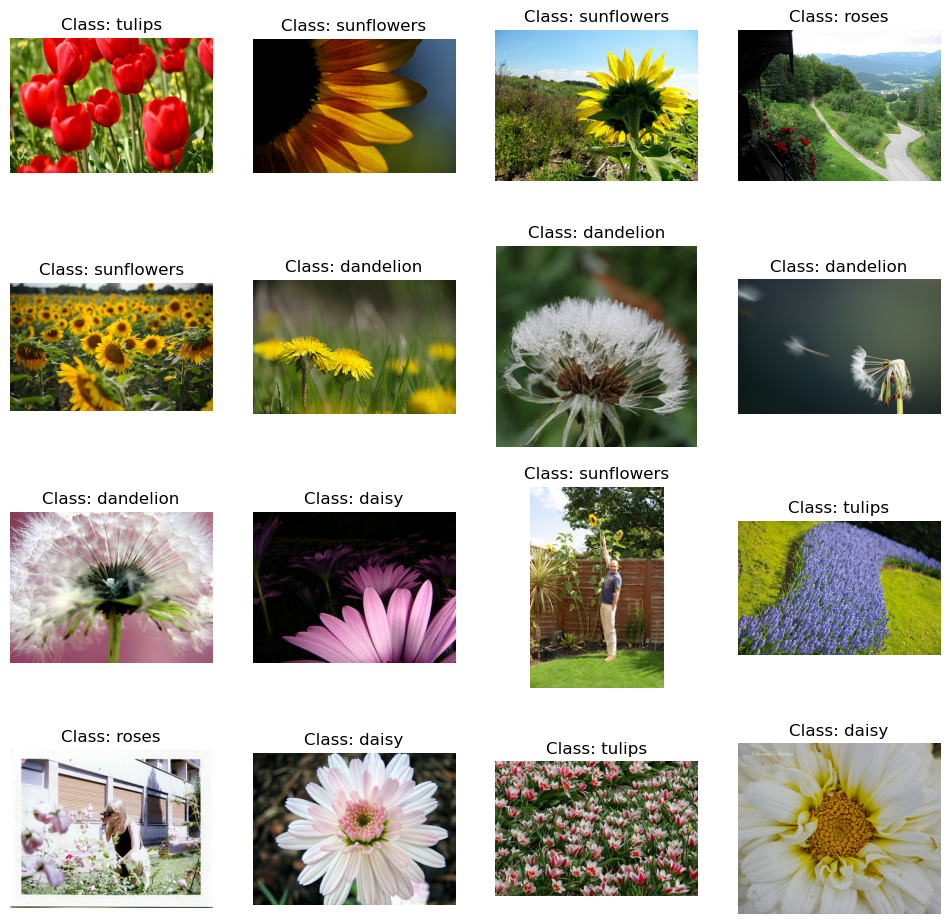

In [9]:
# Original images of dataset
plt.figure(figsize=(12, 12))
index = 0
for image, label in train_set_raw.take(16):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
    print(image.shape)

plt.show()

In [10]:
# Creating table for tabulating train, validation and test accuracy of all three models: 'Xception', 'ResNet50', 'InceptionV3'
import pandas as pd
model_test_accuracy=[]
model_train_accuracy=[]
model_val_accuracy=[]
data = {'Model':['Xception','ResNet50','InceptionV3']}
Table1 = pd.DataFrame(data)

# 2. Preprocessing the dataset:

In [11]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [12]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

2023-11-16 02:57:28.643337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]
2023-11-16 02:57:28.643775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-11-16 02:57:28.916868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


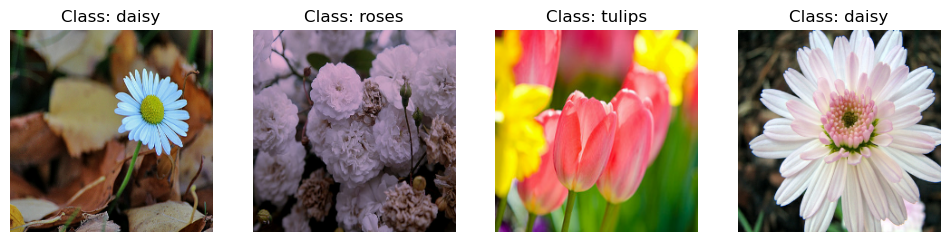

In [13]:
# Images for training:
plt.figure(figsize=(12,12))
for X_batch, y_batch in train_set.take(1):
    for index in range(4):
        plt.subplot(1,4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
        print(X_batch.shape)

plt.show()

2023-11-16 02:57:29.154710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-16 02:57:29.155094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-11-16 02:57:29.226127: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


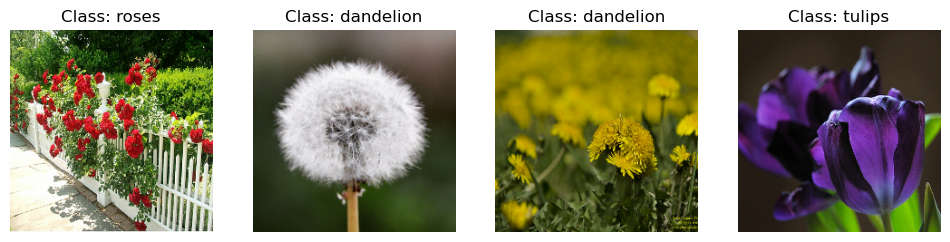

In [14]:
# Images for testing:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(4):
        plt.subplot(1, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
        print(X_batch.shape)

plt.show()

# 3. Creating model with Xception:

In [15]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_class, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [16]:
for index, layer in enumerate(model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [17]:
# Custom callback for learning rate decay
class SGDLearningRateDecay(keras.callbacks.Callback):
    def __init__(self, initial_lr, decay):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay = decay
        self.iterations = 0

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1
        lr = self.initial_lr / (1 + self.decay * self.iterations)
        keras.backend.set_value(self.model.optimizer.lr, lr)

In [18]:
# Training with frozen base model layers
for layer in base_model.layers:
    layer.trainable = False

lr = 0.2
decay = 0.01

# Compiling the model
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Creating the learning rate decay callback
lr_decay_callback = SGDLearningRateDecay(lr, decay)

# Training the model
history = model.fit(train_set,
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.1 * dataset_size / batch_size),
                    epochs=5,
                    callbacks=[lr_decay_callback])

Epoch 1/5


2023-11-16 02:57:30.523606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-11-16 02:57:30.524034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2]
	 [[{{node Placeholder/_1}}]]
2023-11-16 02:57:33.928744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901


 1/91 [..............................] - ETA: 7:30 - loss: 1.6136 - accuracy: 0.1562

2023-11-16 02:57:35.383854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-16 02:57:35.450962: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x34ae09a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-16 02:57:35.450983: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-16 02:57:35.506535: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 [==============================] - ETA: 0s - loss: 1.3586 - accuracy: 0.7950

2023-11-16 02:57:36.953989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-11-16 02:57:36.954377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


91/91 [==============================] - 7s 24ms/step - loss: 1.3586 - accuracy: 0.7950 - val_loss: 0.6930 - val_accuracy: 0.8864
Epoch 2/5
91/91 [==============================] - 1s 16ms/step - loss: 0.4100 - accuracy: 0.9141 - val_loss: 0.4957 - val_accuracy: 0.8835
Epoch 3/5
91/91 [==============================] - 2s 17ms/step - loss: 0.1944 - accuracy: 0.9468 - val_loss: 0.3978 - val_accuracy: 0.9006
Epoch 4/5
91/91 [==============================] - 1s 16ms/step - loss: 0.1264 - accuracy: 0.9588 - val_loss: 0.5412 - val_accuracy: 0.8778
Epoch 5/5
91/91 [==============================] - 1s 16ms/step - loss: 0.0976 - accuracy: 0.9705 - val_loss: 0.3793 - val_accuracy: 0.9119


In [19]:
# Fine-tuning with unfrozen base model layers
for layer in base_model.layers:
    layer.trainable = True

lr = 0.01
decay = 0.001

# Compiling the model
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Creating the learning rate decay callback
lr_decay_callback = SGDLearningRateDecay(lr, decay)

# Training the model
history = model.fit(train_set,
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.1 * dataset_size / batch_size),
                    epochs=40,
                    callbacks=[lr_decay_callback])

Epoch 1/40
91/91 [==============================] - 18s 70ms/step - loss: 0.3283 - accuracy: 0.8925 - val_loss: 0.2557 - val_accuracy: 0.9233
Epoch 2/40
91/91 [==============================] - 6s 65ms/step - loss: 0.0587 - accuracy: 0.9808 - val_loss: 0.2223 - val_accuracy: 0.9290
Epoch 3/40
91/91 [==============================] - 6s 65ms/step - loss: 0.0195 - accuracy: 0.9928 - val_loss: 0.2565 - val_accuracy: 0.9403
Epoch 4/40
91/91 [==============================] - 6s 65ms/step - loss: 0.0269 - accuracy: 0.9921 - val_loss: 0.3028 - val_accuracy: 0.9375
Epoch 5/40
91/91 [==============================] - 6s 65ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.2402 - val_accuracy: 0.9460
Epoch 6/40
91/91 [==============================] - 6s 65ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.2471 - val_accuracy: 0.9432
Epoch 7/40
91/91 [==============================] - 6s 65ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.2734 - val_accuracy: 0.9403
Epoch 8/40
9

In [20]:
model_train_accuracy.append(history.history['accuracy'][-1])
model_val_accuracy.append(history.history['val_accuracy'][-1])

In [21]:
# Testing Model
ls, accu = model.evaluate(test_set)

 1/12 [=>............................] - ETA: 1s - loss: 0.1829 - accuracy: 0.9375

2023-11-16 03:01:54.040840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-11-16 03:01:54.041225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


12/12 [==============================] - 0s 24ms/step - loss: 0.1421 - accuracy: 0.9537


In [22]:
model_test_accuracy.append(accu)

In [23]:
validation_accuracies = history.history['val_accuracy']
best_val_accuracy = max(validation_accuracies)
best_epoch = validation_accuracies.index(best_val_accuracy) + 1
print(f"Best Validation Accuracy: {best_val_accuracy*100:.2f}% achieved at epoch: {best_epoch}")

Best Validation Accuracy: 95.45% achieved at epoch: 12


2023-11-16 03:01:54.498480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-16 03:01:54.498927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 28ms/step


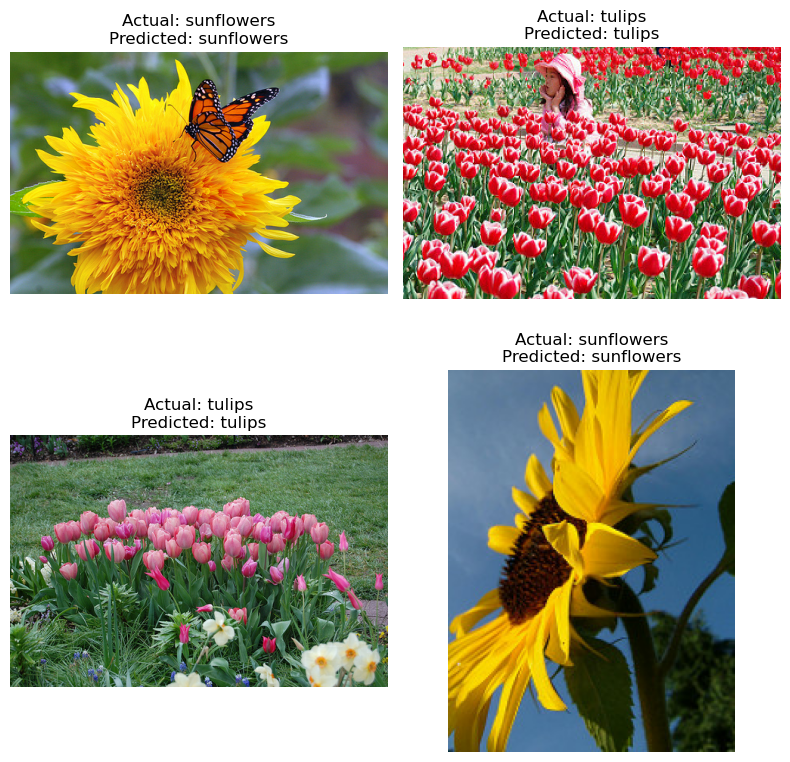

In [24]:
# Display 4 random images in a 2x2 grid
plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(test_set_raw.shuffle(1000).take(4)):
    processed_image = tf.image.resize(image, [224, 224])
    processed_image = keras.applications.xception.preprocess_input(processed_image)
    prediction = np.argmax(model.predict(np.expand_dims(processed_image, axis=0)), axis=1)

    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[prediction[0]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# 4. Preprocssing data for model with ResNet50

In [25]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.resnet.preprocess_input(resized_image)
    return final_image, label

In [26]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

## Creating model with ResNet50

In [27]:
base_model1 = keras.applications.resnet.ResNet50(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model1.output)
output = keras.layers.Dense(n_class, activation="softmax")(avg)
model1 = keras.models.Model(inputs=base_model1.input, outputs=output)

In [28]:
for index, layer in enumerate(model1.layers):
    print(index, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [29]:
# Training with frozen base model layers
for layer in base_model1.layers:
    layer.trainable = False

lr = 0.2
decay = 0.01

# Compiling the model
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
model1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

lr_decay_callback = SGDLearningRateDecay(lr, decay)

# Training the model
history1 = model1.fit(train_set,
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.1 * dataset_size / batch_size),
                    epochs=5,
                    callbacks=[lr_decay_callback])

Epoch 1/5


2023-11-16 03:01:57.176148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2]
	 [[{{node Placeholder/_1}}]]
2023-11-16 03:01:57.176579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]


89/91 [============================>.] - ETA: 0s - loss: 10.9998 - accuracy: 0.8090

2023-11-16 03:02:00.763493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-11-16 03:02:00.763899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


91/91 [==============================] - 4s 23ms/step - loss: 10.9007 - accuracy: 0.8104 - val_loss: 6.2752 - val_accuracy: 0.8807
Epoch 2/5
91/91 [==============================] - 1s 15ms/step - loss: 3.0880 - accuracy: 0.9255 - val_loss: 4.8193 - val_accuracy: 0.9034
Epoch 3/5
91/91 [==============================] - 1s 15ms/step - loss: 1.3410 - accuracy: 0.9516 - val_loss: 3.5701 - val_accuracy: 0.9091
Epoch 4/5
91/91 [==============================] - 1s 15ms/step - loss: 0.7564 - accuracy: 0.9650 - val_loss: 3.6540 - val_accuracy: 0.9006
Epoch 5/5
91/91 [==============================] - 1s 15ms/step - loss: 0.6373 - accuracy: 0.9663 - val_loss: 3.7282 - val_accuracy: 0.9034


In [30]:
# Fine-tuning with unfrozen base model layers
for layer in base_model1.layers:
    layer.trainable = True

lr = 0.0001
decay = 0.001

# Compiling the model
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
model1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

lr_decay_callback = SGDLearningRateDecay(lr, decay)

# Training the model
history1 = model1.fit(train_set,
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.1 * dataset_size / batch_size),
                    epochs=40,
                    callbacks=[lr_decay_callback])

Epoch 1/40
91/91 [==============================] - 18s 54ms/step - loss: 1.8606 - accuracy: 0.9155 - val_loss: 7.6334 - val_accuracy: 0.8182
Epoch 2/40
91/91 [==============================] - 4s 47ms/step - loss: 0.4829 - accuracy: 0.9670 - val_loss: 2.6098 - val_accuracy: 0.9006
Epoch 3/40
91/91 [==============================] - 4s 47ms/step - loss: 0.2109 - accuracy: 0.9845 - val_loss: 2.5819 - val_accuracy: 0.8892
Epoch 4/40
91/91 [==============================] - 4s 47ms/step - loss: 0.1863 - accuracy: 0.9859 - val_loss: 2.2841 - val_accuracy: 0.9176
Epoch 5/40
91/91 [==============================] - 4s 47ms/step - loss: 0.1091 - accuracy: 0.9914 - val_loss: 1.7437 - val_accuracy: 0.9119
Epoch 6/40
91/91 [==============================] - 4s 47ms/step - loss: 0.0786 - accuracy: 0.9935 - val_loss: 1.8084 - val_accuracy: 0.9205
Epoch 7/40
91/91 [==============================] - 4s 47ms/step - loss: 0.0373 - accuracy: 0.9938 - val_loss: 1.8945 - val_accuracy: 0.9148
Epoch 8/40
9

In [31]:
model_train_accuracy.append(history1.history['accuracy'][-1])
model_val_accuracy.append(history1.history['val_accuracy'][-1])

In [32]:
# Testing Model
ls1, accu1 =  model1.evaluate(test_set)

 5/12 [===========>..................] - ETA: 0s - loss: 0.7993 - accuracy: 0.9625

2023-11-16 03:05:12.027005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-16 03:05:12.027396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


12/12 [==============================] - 0s 34ms/step - loss: 0.5603 - accuracy: 0.9673


In [33]:
model_test_accuracy.append(accu1)

In [34]:
validation_accuracies = history1.history['val_accuracy']
best_val_accuracy = max(validation_accuracies)
best_epoch = validation_accuracies.index(best_val_accuracy) + 1
print(f"Best Validation Accuracy: {best_val_accuracy*100:.2f}% achieved at epoch: {best_epoch}")

Best Validation Accuracy: 92.05% achieved at epoch: 6


1/1 [==============================] - 0s 28ms/step


2023-11-16 03:09:55.865161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-16 03:09:55.865642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 28ms/step


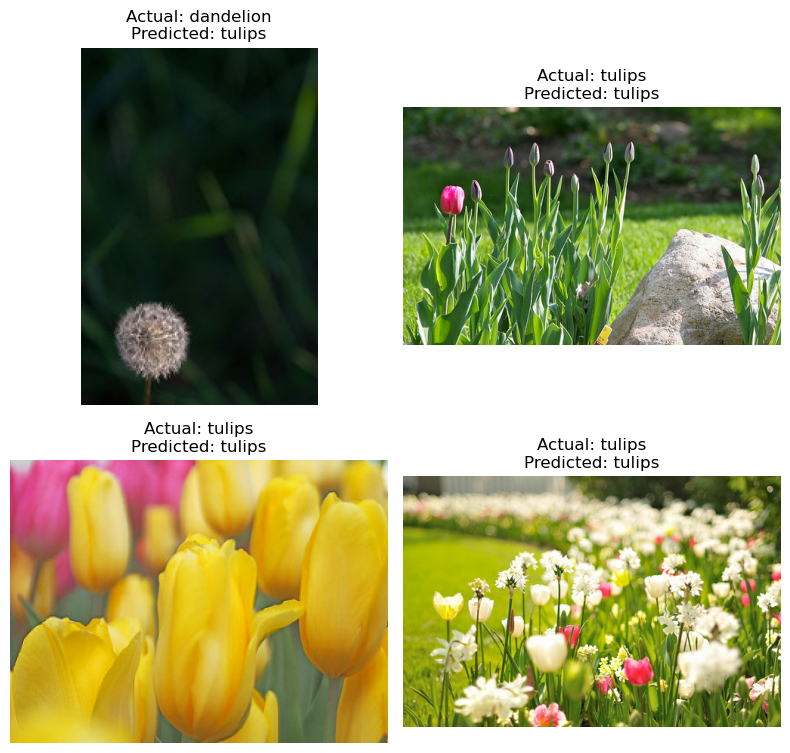

In [55]:
# Display 4 random images in a 2x2 grid
plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(test_set_raw.shuffle(1000).take(4)):
    processed_image = tf.image.resize(image, [224, 224])
    processed_image = keras.applications.xception.preprocess_input(processed_image)
    prediction = np.argmax(model1.predict(np.expand_dims(processed_image, axis=0)), axis=1)

    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[prediction[0]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Preprocessing data for model with InceptionV3

In [36]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.inception_v3.preprocess_input(resized_image)
    return final_image, label

In [37]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

## Creating model with InceptionV3

In [38]:
base_model2 = keras.applications.inception_v3.InceptionV3(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model2.output)
output = keras.layers.Dense(n_class, activation="softmax")(avg)
model2 = keras.models.Model(inputs=base_model2.input, outputs=output)

In [39]:
for index, layer in enumerate(model2.layers):
    print(index, layer.name)

0 input_3
1 conv2d_4
2 batch_normalization_4
3 activation
4 conv2d_5
5 batch_normalization_5
6 activation_1
7 conv2d_6
8 batch_normalization_6
9 activation_2
10 max_pooling2d
11 conv2d_7
12 batch_normalization_7
13 activation_3
14 conv2d_8
15 batch_normalization_8
16 activation_4
17 max_pooling2d_1
18 conv2d_12
19 batch_normalization_12
20 activation_8
21 conv2d_10
22 conv2d_13
23 batch_normalization_10
24 batch_normalization_13
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_9
29 conv2d_11
30 conv2d_14
31 conv2d_15
32 batch_normalization_9
33 batch_normalization_11
34 batch_normalization_14
35 batch_normalization_15
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_19
42 batch_normalization_19
43 activation_15
44 conv2d_17
45 conv2d_20
46 batch_normalization_17
47 batch_normalization_20
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_16
52 conv2d_18
53 conv2d_21
54 conv2d_22
55 batch_normalization_16
56 batch_normal

In [40]:
# Training with frozen base model layers
for layer in base_model2.layers:
    layer.trainable = False

lr = 0.2
decay = 0.01

# Compiling the model
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

lr_decay_callback = SGDLearningRateDecay(lr, decay)

# Training the model
history2 = model2.fit(train_set,
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.1 * dataset_size / batch_size),
                    epochs=5,
                    callbacks=[lr_decay_callback])

Epoch 1/5


2023-11-16 03:05:15.911456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]
2023-11-16 03:05:15.911889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]


91/91 [==============================] - ETA: 0s - loss: 15.5045 - accuracy: 0.7225

2023-11-16 03:05:20.574560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-16 03:05:20.574961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


91/91 [==============================] - 6s 23ms/step - loss: 15.5045 - accuracy: 0.7225 - val_loss: 7.3352 - val_accuracy: 0.8523
Epoch 2/5
91/91 [==============================] - 1s 13ms/step - loss: 4.5103 - accuracy: 0.8729 - val_loss: 5.4451 - val_accuracy: 0.8693
Epoch 3/5
91/91 [==============================] - 1s 13ms/step - loss: 2.2741 - accuracy: 0.9193 - val_loss: 4.5236 - val_accuracy: 0.8778
Epoch 4/5
91/91 [==============================] - 1s 13ms/step - loss: 1.4709 - accuracy: 0.9368 - val_loss: 4.9635 - val_accuracy: 0.8608
Epoch 5/5
91/91 [==============================] - 1s 13ms/step - loss: 1.0954 - accuracy: 0.9416 - val_loss: 4.0040 - val_accuracy: 0.8693


In [41]:
# Fine-tuning with unfrozen base model layers
for layer in base_model2.layers:
    layer.trainable = True

lr = 0.0001
decay = 0.001

# Compiling the model
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

lr_decay_callback = SGDLearningRateDecay(lr, decay)

# Training the model
history2 = model2.fit(train_set,
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.1 * dataset_size / batch_size),
                    epochs=40,
                    callbacks=[lr_decay_callback])

Epoch 1/40
91/91 [==============================] - 20s 55ms/step - loss: 2.6691 - accuracy: 0.7970 - val_loss: 3.9321 - val_accuracy: 0.8466
Epoch 2/40
91/91 [==============================] - 4s 45ms/step - loss: 0.5347 - accuracy: 0.9138 - val_loss: 1.5711 - val_accuracy: 0.9006
Epoch 3/40
91/91 [==============================] - 4s 45ms/step - loss: 0.1867 - accuracy: 0.9584 - val_loss: 1.0689 - val_accuracy: 0.9176
Epoch 4/40
91/91 [==============================] - 4s 45ms/step - loss: 0.0966 - accuracy: 0.9808 - val_loss: 0.9291 - val_accuracy: 0.9205
Epoch 5/40
91/91 [==============================] - 4s 45ms/step - loss: 0.0874 - accuracy: 0.9804 - val_loss: 0.8239 - val_accuracy: 0.9119
Epoch 6/40
91/91 [==============================] - 4s 45ms/step - loss: 0.0673 - accuracy: 0.9808 - val_loss: 0.8510 - val_accuracy: 0.9176
Epoch 7/40
91/91 [==============================] - 4s 45ms/step - loss: 0.0421 - accuracy: 0.9890 - val_loss: 0.7784 - val_accuracy: 0.9261
Epoch 8/40
9

In [42]:
model_train_accuracy.append(history2.history['accuracy'][-1])
model_val_accuracy.append(history2.history['val_accuracy'][-1])

In [43]:
# Testing Model
ls2, accu2 = model2.evaluate(test_set)

11/12 [==========================>...] - ETA: 0s - loss: 0.7163 - accuracy: 0.8949

2023-11-16 03:08:25.028075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-16 03:08:25.028477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 1s 50ms/step - loss: 0.6870 - accuracy: 0.8992


In [44]:
model_test_accuracy.append(accu2)

In [45]:
validation_accuracies = history2.history['val_accuracy']
best_val_accuracy = max(validation_accuracies)
best_epoch = validation_accuracies.index(best_val_accuracy) + 1
print(f"Best Validation Accuracy: {best_val_accuracy*100:.2f}% achieved at epoch: {best_epoch}")

Best Validation Accuracy: 93.18% achieved at epoch: 28


1/1 [==============================] - 0s 29ms/step


2023-11-16 03:09:36.182956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-11-16 03:09:36.183371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 29ms/step


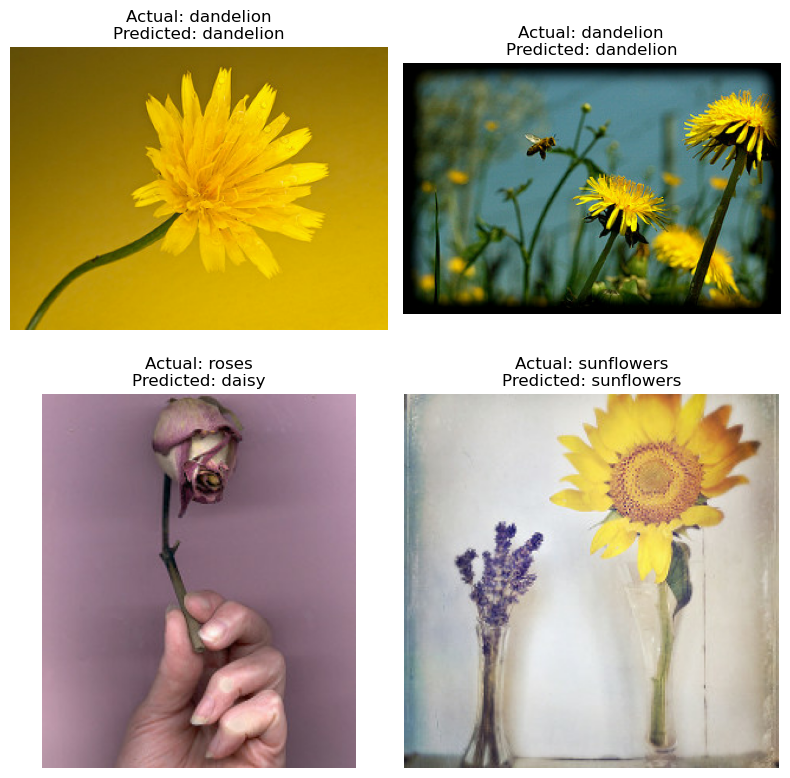

In [53]:
# Display 4 random images in a 2x2 grid
plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(test_set_raw.shuffle(1000).take(4)):
    processed_image = tf.image.resize(image, [224, 224])
    processed_image = keras.applications.xception.preprocess_input(processed_image)
    prediction = np.argmax(model2.predict(np.expand_dims(processed_image, axis=0)), axis=1)

    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[prediction[0]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [47]:
Table1['Train Accuracy'] = model_train_accuracy
Table1['Validation Accuracy'] = model_val_accuracy
Table1['Test Accuracy'] = model_test_accuracy

# Displaying the DataFrame
print(Table1)

         Model  Train Accuracy  Validation Accuracy  Test Accuracy
0     Xception        0.999657             0.954545       0.953678
1     ResNet50        0.998626             0.906250       0.967302
2  InceptionV3        0.998283             0.923295       0.899183


In [59]:
def print_best_val_accuracy(history, history_name):
    validation_accuracies = history.history['val_accuracy']
    best_val_accuracy = max(validation_accuracies)
    best_epoch = validation_accuracies.index(best_val_accuracy) + 1
    print(f"Best Validation Accuracy for {history_name}: {best_val_accuracy*100:.2f}% achieved at epoch: {best_epoch}")

print_best_val_accuracy(history, "Xception")
print_best_val_accuracy(history1, "ResNet50")
print_best_val_accuracy(history2, "InceptionV3")

Best Validation Accuracy for Xception: 95.45% achieved at epoch: 12
Best Validation Accuracy for ResNet50: 92.05% achieved at epoch: 6
Best Validation Accuracy for InceptionV3: 93.18% achieved at epoch: 28


## Some data augmentation functions from TensorFlow and Keras that could have been used:

1. ImageDataGenerator (Keras): Generates batches of tensor image data with real-time data augmentation.
2. RandomFlip (TensorFlow): Randomly flips an image horizontally or vertically.
3. RandomRotation (TensorFlow): Randomly rotates the image by a specified degree.
4. RandomZoom (TensorFlow): Randomly zooms the image in and out.
5. RandomTranslation (TensorFlow): Translates the image randomly in horizontal and vertical directions.
6. RandomContrast (TensorFlow): Adjusts the contrast of the image randomly.
7. RandomBrightness (TensorFlow): Randomly adjusts the brightness of the image.
8. Rescaling (TensorFlow): Normalizes the pixel values of the image.